1 nH: min |S11| = -34.5 dB at 3.780 GHz
100 nH: min |S11| = -47.1 dB at 5.025 GHz
Finished running notebook with detailed formulas and explanations.


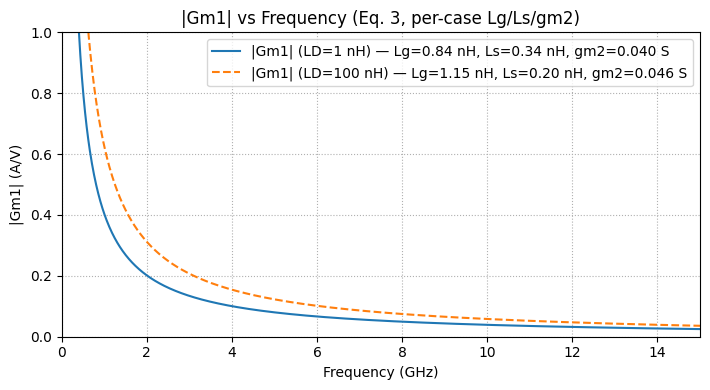

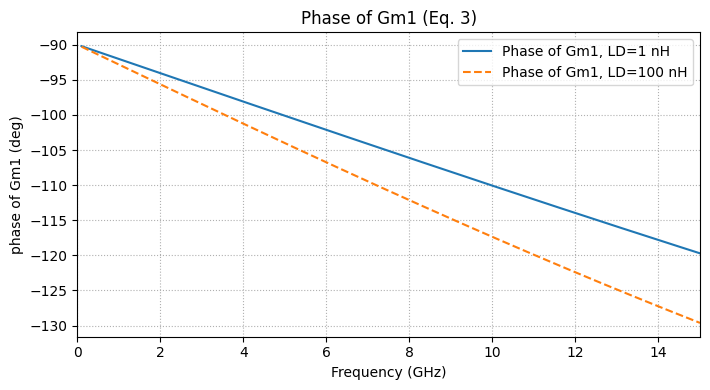

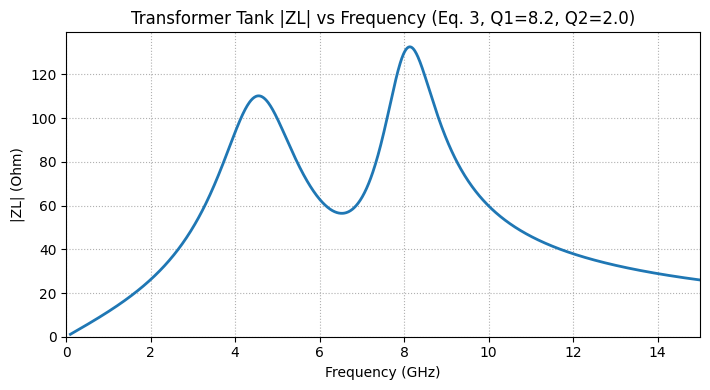

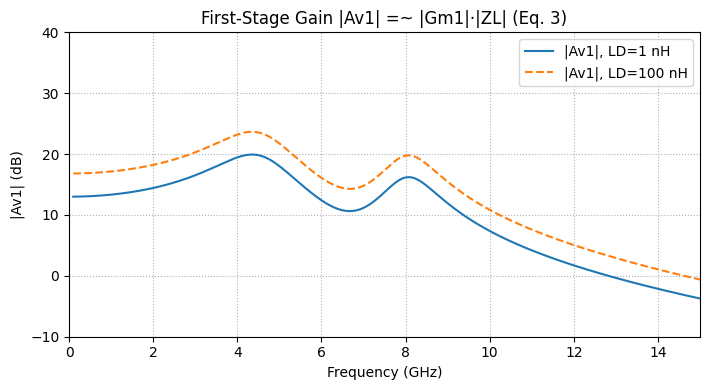

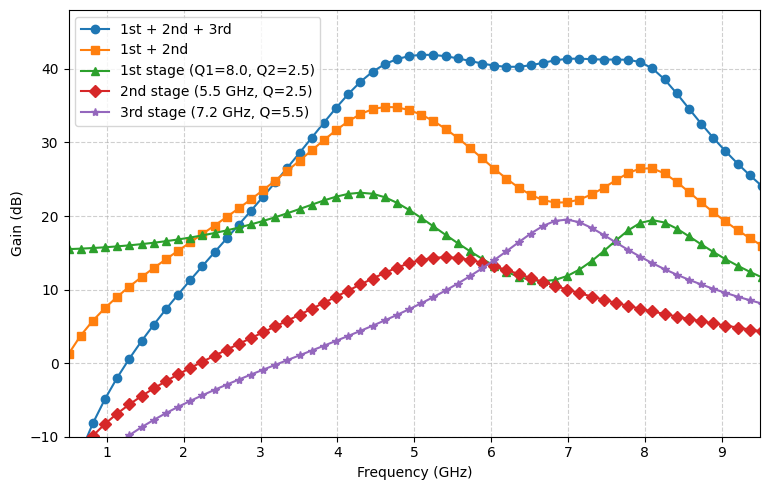

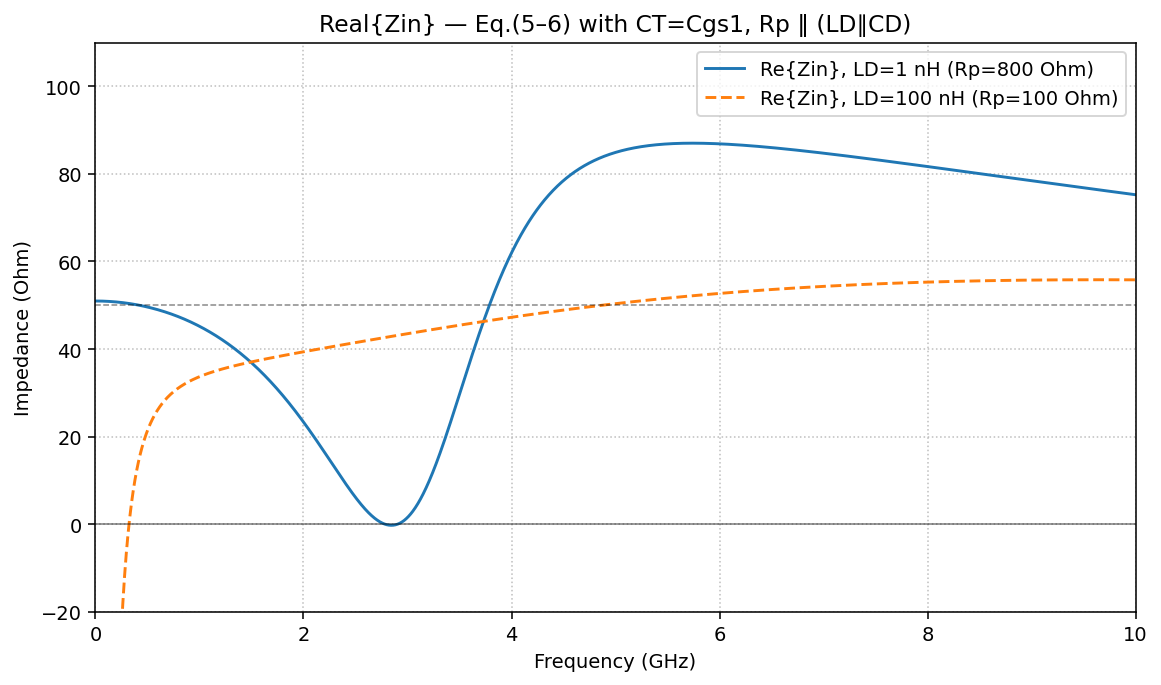

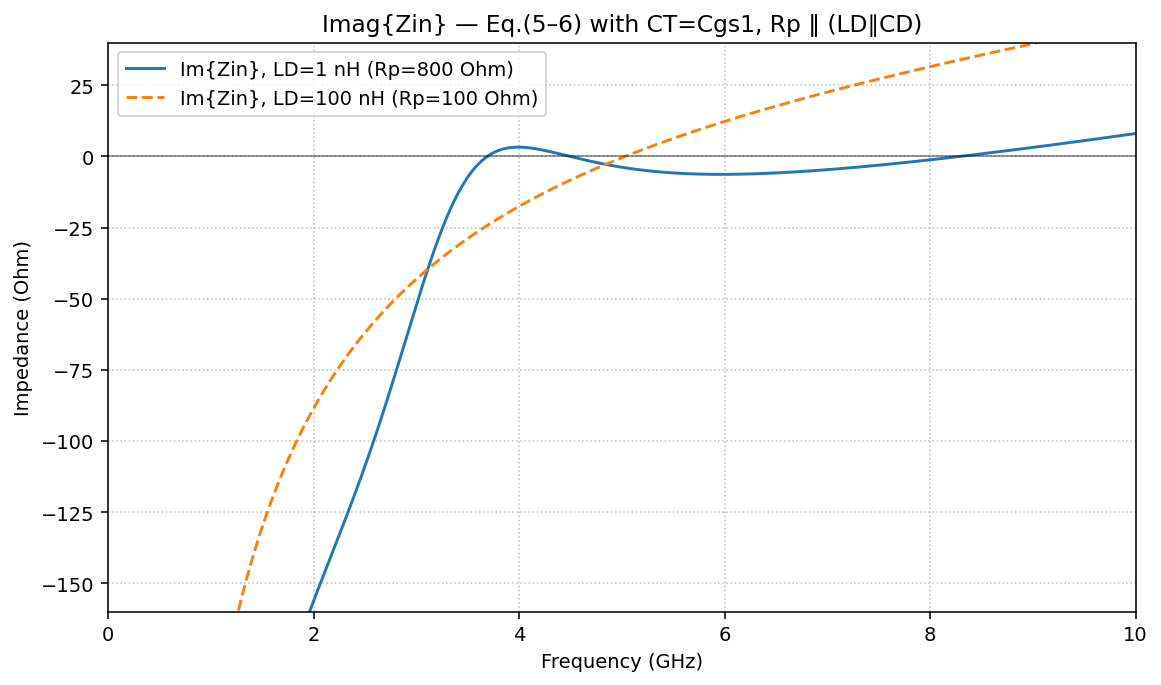

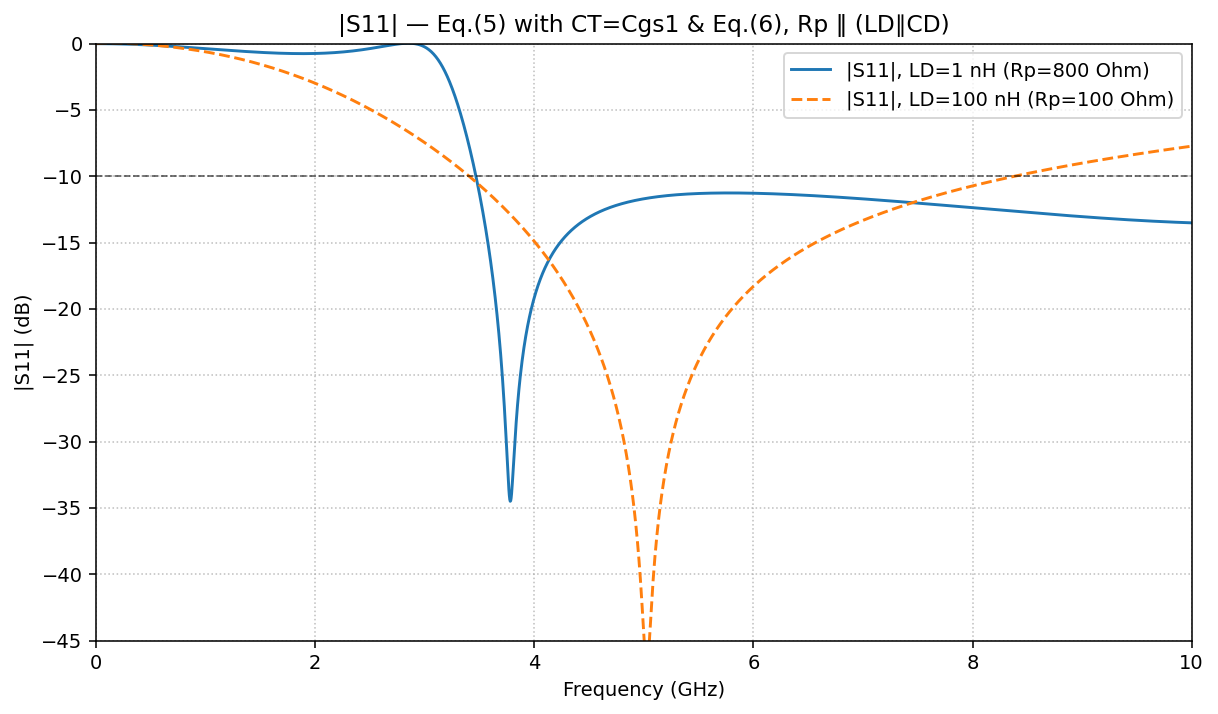

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# CryoLNA 1st–3rd stage analytical notebook
#
# Order of plots:
#   A) First-stage building blocks:
#      1) |Gm1(f)| for two LD cases
#      2) Phase of Gm1(f) for two LD cases
#      3) |ZL(f)| of transformer tank
#      4) |Av1(f)| ~= |Gm1|·|ZL|
#   B) Cascaded gain vs frequency (1st + 2nd + 3rd stages)
#   C) Input impedance & |S11| from Eq. (5)–(6) for LD = 1 nH / 100 nH
#
# All parameter values are kept consistent with the paper as well AS THE slides value used.


j = 1j
Z0 = 50.0  # reference impedance (Ohm)


# Common first-stage device parameters (paper caption)

gm1  = 0.22       # S
Cgs1 = 0.24e-12   # F
Cgd1 = 90e-15     # F
Gds1 = 33e-3      # S
Cgs2 = 95e-15     # F
Rs   = 50.0       # Ohm (source / system impedance)

# "Design" values for first-stage LS, LG, gm2 (used in cascaded-gain plot)
Ls_design  = 0.25e-9   # H
Lg_design  = 0.85e-9   # H
gm2_design = 0.10      # S

# Eq.(5)–(6) cases for LD = 1 nH and 100 nH (EXACT values)
# These are used in:
#   - Gm1(f) / phase plots (with their own Lg/Ls/gm2)
#   - Zin / S11 plots

case_1nH = dict(
    LG=0.84e-9,
    LS=0.34e-9,
    LD=1.0e-9,
    CD=2.60e-12,
    gm2_case=0.040,
    Rp=800.0
)

case_100nH = dict(
    LG=1.150e-9,
    LS=0.20e-9,
    LD=100e-9,
    CD=1.50e-12,
    gm2_case=0.046,
    Rp=100.0
)


# Transformer tank shared constants (from paper Fig. 2)

L11, L12 = 1.9e-9, 1.6e-9
C11, C12 = 0.5e-12, 0.5e-12
k  = 0.55  # magnetic coupling coefficient between L11 and L12

# Qs used for shunt resistance in the transformer tank
# Parallel RLC Q–Rp relations (at resonance):
#   w0 = 2pi f0 = 1/sqrt(L*C)
#   Qp = Rp / (w0 L) = Rp * w0 * C
#   Rp = Qp * w0 * L = Qp / (w0 * C)
Q1, Q2 = 8.2, 2.0   # for Eq.(3) / Av1 plots (to match Fig. 2 shape)
Q3, Q4 = 8.0, 2.5   # for cascaded (1st+2nd+3rd) gain plot

GHz = lambda f: f/1e9   # convenience lambda for axis scaling


# 1) Core helper functions


def Z_LC_parallel_Rp(w, L, C, Rp):
    """
    Impedance of a parallel RLC network: Rp || L || C.

    Parallel RLC:
        Y_total(w) = 1/(j*w*L) + j*w*C + 1/Rp
        Z_total(w) = 1 / Y_total(w)

    compute Y_total first (admittance) and then invert, which is:
      - Numerically robust
      - Conceptually simple for parallel branches

    Parameters
    ----------
    w : ndarray or float
        Angular frequency w [rad/s].
    L : float
        Inductance L [H].
    C : float
        Capacitance C [F].
    Rp : float or None
        Parallel resistance [Ohm]. If Rp is None or infinite, we treat the
        resistive branch as open (no 1/Rp term).

    Returns
    -------
    Z : complex ndarray or complex
        Complex impedance of Rp || L || C seen from the terminals.
    """
    Gp = 0.0 if (Rp is None or np.isinf(Rp)) else 1.0/Rp
    Y = (1.0/(1j*w*L)) + (1j*w*C) + Gp
    ## Parallel RLC in admittance form:
    # Gp = 1 /Rp
#   Y(w) = 1/(jwL) + jwC + 1/Rp   (if Rp finite)
#        = 1/(jwL) + jwC          (if Rp is None or infinity)
#   Z(w) = 1 / Y(w)
    return 1.0 / (Y + 0.0j)


def ZD(w, LD, CD, gm2, Rp):
    """
    Drain-side shunt network used in Eq. (6): Z_D(w) = 1/gm2 + Z_LC_parallel_Rp.

    Physically:
      - 1/gm2 models the finite output resistance of the cascode device.
      - Z_LC_parallel_Rp models LD || CD with finite Q (via Rp).

    Parameters
    ----------
    w : ndarray
        Angular frequency w [rad/s].
    LD, CD : float
        Drain inductor and capacitor values [H, F].
    gm2 : float
        Cascode transistor transconductance [S], used as 1/gm2 here.
    Rp : float
        Parallel resistance across the LD||CD tank [Ohm].

    Returns
    -------
    ZD : ndarray of complex
        Effective shunt impedance seen at the drain node.
    """
    return (1.0/gm2) + Z_LC_parallel_Rp(w, LD, CD, Rp)


def Zin_core_eq56(w, LD, CD, LS, gm2, Rp):
    """
    Core input impedance expression from Eq. (5)–(6), with C_T = Cgs1.

    Uses the paper's derived formula for the M1 + LS + ZD network.
    Very compactly:

        Z_D(w) = 1/gm2 + Z_LC_parallel_Rp(LD, CD, Rp)
        T(w)   = j*w*LS * (gm1 + j*w*Cgs1 + Gds1)
        C_T    = Cgs1

        numerator:
          num = (1 + j*w*Cgd1*Z_D)*(1 + T)
                + Z_D*Gds1*(1 - w^2*LS*Cgs1)

        denominator:
          den = j*w * [ (Z_D + j*w*LS)
                        * (Gds1*C_T + Cgd1*(gm1 + j*w*Cgs1))
                        + C_T ]

        Zin_core(w) = num / den

    This returns Zin at the gate *before* adding LG in series.

    Parameters
    ----------
    w : ndarray
        Angular frequency w [rad/s].
    LD, CD : float
        Drain inductor and capacitor for the first-stage tank [H, F].
    LS : float
        Source inductance [H].
    gm2 : float
        Cascode transconductance (used inside ZD) [S].
    Rp : float
        Parallel resistance across LD||CD [Ohm].

    Returns
    -------
    Zin_core : ndarray of complex
        Core input impedance at the gate node as given by Eq.(5)–(6).
    """
    Zd = ZD(w, LD, CD, gm2, Rp)
    CT = Cgs1
    T  = 1j*w*LS*(gm1 + 1j*w*Cgs1 + Gds1)
    num = (1 + 1j*w*Cgd1*Zd)*(1 + T) + Zd*Gds1*(1 - (w**2)*LS*Cgs1)
    den = 1j*w * ((Zd + 1j*w*LS)*(Gds1*CT + Cgd1*(gm1 + 1j*w*Cgs1)) + CT)
    return num / den


def Zin_port(w, LG, LD, CD, LS, gm2, Rp):
    """
    Total input impedance Zin(f) as seen from the 50 Ohm source.

    Series LG is added in front of the core gate impedance:

        Zin_port(w) = j*w*LG + Zin_core_eq56(w, ...)

    Parameters
    ----------
    w : ndarray
        Angular frequency w [rad/s].
    LG : float
        Gate inductor at the input [H].
    LD, CD, LS, gm2, Rp : float
        See Zin_core_eq56 and ZD.

    Returns
    -------
    Zin : ndarray of complex
        Full input impedance vs frequency.
    """
    return 1j*w*LG + Zin_core_eq56(w, LD, CD, LS, gm2, Rp)


def S11_dB(Zin, Z0=50.0):
    """
    Reflection coefficient magnitude |S11| in dB for a given Zin(f).

    For a one-port with reference Z0:

        Reflection Coeficent = gamma
        gamma(w)       = (Zin(w) - Z0) / (Zin(w) + Z0)
        |S11(w)|   = |gamma(w)|
        |S11|_dB   = 20*log10(|gamma|)

    A tiny floor (1e-20) is added inside the log to avoid -inf.

    Parameters
    ----------
    Zin : complex ndarray
        Input impedance vs frequency.
    Z0 : float
        Reference impedance [Ohm], typically 50 Ohm.

    Returns
    -------
    S11_dB : ndarray of float
        Reflection coefficient magnitude in dB.
    """
    return 20*np.log10(np.maximum(np.abs((Zin - Z0)/(Zin + Z0)), 1e-20))


def gm1_eff_eq3(f_Hz, gm1, gm2, Cgs1, Cgs2, Ls, Lg, Rs=50.0):
    """
    Effective first-stage transconductance Gm1(f) from Eq. (3).

    Concept:
      - Solve the input network of M1 with source/gate inductors and Rs.
      - Include capacitive division through Cgs1 and the cascode pole by Cgs2.
      - Result is a *frequency-dependent* complex Gm1_eff(w).

    Model (compact form used in the paper):

        w   = 2pi f
        den = j*w*Cgs1 * ( j*w*(Ls + Lg) + Rs ) + j*w*gm1*Ls
        cas = gm2 / (j*w*Cgs2 + gm2)

        Gm1_eff(w) = gm1 / den * cas

    Parameters
    ----------
    f_Hz : ndarray
        Frequency in Hz.
    gm1 : float
        Transconductance of M1 [S].
    gm2 : float
        Transconductance of M2 (cascode) [S].
    Cgs1, Cgs2 : float
        Gate-source capacitances of M1 and M2 [F].
    Ls, Lg : float
        Source and gate inductances [H].
    Rs : float
        Source resistance at the input (usually 50 Ohm).

    Returns
    -------
    Gm1_eff : complex ndarray
        Complex effective Gm1(f) in A/V; magnitude gives |Gm1|.
    """
    w  = 2*np.pi*f_Hz
    jw = 1j*w
    den = jw*Cgs1*(jw*(Ls+Lg) + Rs) + jw*gm1*Ls      # gate/source
    cas = gm2/(jw*Cgs2 + gm2)                        # cascode roll-off
    return gm1/den * cas


def ZL_transformer(f_Hz, Q1, Q2):
    """
    Input impedance ZL(f) of the transformer-coupled tank.

    Two coupled inductors L11, L12 with mutual inductance:

        M  = k * sqrt(L11 * L12)
        delta_L = L11*L12 - M^2

    write the 2×2 admittance matrix:

        Y11 = G1 + j*w*C11 + L12 / (j*w*delta_L)
        Y22 = G2 + j*w*C12 + L11 / (j*w*delta_L)
        Y12 = j*M / (w*delta_L)

    where finite Q is modeled by:
        G1 = 1 / (w * L11 * Q1)
        G2 = 1 / (w * L12 * Q2)

    Then the input admittance at port 1 is:
        Y_in = Y11 - Y12^2 / Y22

    and the load impedance is:
        ZL(w) = 1 / Y_in(w)

    Parameters
    ----------
    f_Hz : ndarray
        Frequency in Hz.
    Q1, Q2 : float
        Parallel Q-factors of the two inductors (implemented via shunt G).

    Returns
    -------
    ZL : complex ndarray
        Complex load impedance vs frequency (as seen from primary side).
    """
    w = 2*np.pi*f_Hz
    M = k*np.sqrt(L11*L12)
    DL = L11*L12 - M*M
    G1 = 1.0/np.maximum(w*L11*Q1, 1e-12)
    G2 = 1.0/np.maximum(w*L12*Q2, 1e-12)
    Y11 = G1 + 1j*w*C11 + L12/(1j*w*DL)
    Y22 = G2 + 1j*w*C12 + L11/(1j*w*DL)
    Y12 = (1j*M)/(w*DL)
    Yin = Y11 - (Y12*Y12)/Y22
    return 1.0/Yin


def Y_tank(w, L, C, Rp):
    """
    Admittance of a simple parallel RLC load: Rp || L || C.

    Same physical structure as Z_LC_parallel_Rp, but directly as admittance:

        Y_tank(w) = 1/Rp + j*w*C + 1/(j*w*L)

    This is convenient to work on the 2nd and 3rd stages.

    Parameters
    ----------
    w : float
        Angular frequency w [rad/s].
    L, C : float
        Inductance and capacitance [H, F].
    Rp : float
        Parallel resistance [Ohm].

    Returns
    -------
    Y : complex
        Admittance of the parallel RLC network.
    """
    return (1.0/Rp) + 1j*w*C + 1.0/(1j*w*L)


def Av_gate_cascode(
    f, RB, CB,
    gm_cs, gds_cs, Cgs_cs, Cgd_cs,
    gm_cg, gds_cg, Cgs_cg, Cgd_cg,
    L, C, Rp
):
    """
    CS–CG cascode gain with gate high-pass (CB, RB) and shunt tank at output.

    solveed a 3-node system at each frequency:

        Node 0: gate of CS (M3/M5) with RB to ground and series CB from Vin
        Node 1: drain of CS / source of CG (M4/M6)
        Node 2: drain of CG (output) with parallel RLC (L, C, Rp)

    Input high-pass (series C_B into R_B):

        Y_th(w) = j*w*C_B + 1/R_B
        I_N(w)  = j*w*C_B * Vin   (with Vin = 1 V, I_N = j*w*C_B)

    then solve:
        A(w) · V(w) = b(w)

    and the small-signal gain is:
        A_v(w) = V_y(w) / V_in  (here V_in = 1, so A_v = V_y)

    Parameters
    ----------
    f : ndarray
        Frequency vector [Hz].
    RB : float
        Gate bias resistor [Ohm].
    CB : float
        AC coupling / high-pass capacitor [F].
    gm_cs, gds_cs : float
        Transconductance and output conductance of the CS device [S].
    Cgs_cs, Cgd_cs : float
        CS device capacitances [F].
    gm_cg, gds_cg : float
        Transconductance and output conductance of the CG device [S].
    Cgs_cg, Cgd_cg : float
        CG device capacitances [F].
    L, C, Rp : float
        Output tank L, C, Rp [H, F, Ohm].

    Returns
    -------
    Av : complex ndarray
        Frequency-dependent small-signal gain Vy/Vin (complex).
    """
        # Convert frequency array f [Hz] to angular frequency array w [rad/s]
    w = 2 * np.pi * f

    # Pre-allocate complex array for the gain Av(f) with same shape as f
    Av = np.zeros_like(f, dtype=complex)

    # Loop over each frequency point: k is index, ww is angular frequency w_k
    for k, ww in enumerate(w):

        # Define complex frequency variable s = jw for this frequency point
        s = 1j * ww

        # Initialize 3×3 complex admittance matrix A for nodes [G, X, Y]
        A = np.zeros((3, 3), dtype=complex)

        # Initialize 3×1 complex vector b for current injections at nodes
        b = np.zeros(3, dtype=complex)

        # Input network: Vin=1 V source through series CB into RB||gate

        # Total admittance from gate node to "AC ground" through CB and RB:
        #   Y_th(w) = jw C_B + 1/R_B
        Yth = s * CB + 1.0 / RB  # gate-node shunt admittance from CB and RB

        #  current source into gate node:
        #   I_N(w) = jw C_B * Vin, with Vin = 1 V --> I_N = jw C_B
        IN = s * CB  # injected current at gate node for Vin = 1 V

        # Stamp Y_th into diagonal of node 0 (gate), and IN into b[0]
        A[0, 0] += Yth
        b[0]    += IN

        # CS device contributions between nodes G (0) and X (1)

        # Add Cgs_cs between gate and AC ground at node 0:
        #   admittance jw Cgs_cs to node 0 diagonal
        A[0, 0] += s * Cgs_cs

        # Add Cgd_cs between gate (node 0) and node X (node 1):
        #   +jwC to both diagonals, -jwC to off-diagonal coupling terms
        A[0, 0] += s * Cgd_cs
        A[1, 1] += s * Cgd_cs
        A[0, 1] -= s * Cgd_cs
        A[1, 0] -= s * Cgd_cs

        # Add gm_cs controlled source from gate to node X:
        #   current gm_cs * V_g flows into node X, so stamp +gm_cs at (1,0)
        A[1, 0] += gm_cs

        # Add output conductance gds_cs from node X to ground:
        #   admittance gds_cs to node 1 diagonal
        A[1, 1] += gds_cs

        # CG device  contributions between node X (1) and Y (2)

        # Add Cgs_cg from node X to AC-ground (gate of CG is AC-grounded):
        #   admittance jw Cgs_cg on node 1 diagonal
        A[1, 1] += s * Cgs_cg

        # Add Cgd_cg between node X (1) and node Y (2):
        #   +jwC to both diagonals, then −jwC to off-diagonals if needed
        A[2, 2] += s * Cgd_cg

        # Add transconductance gm_cg from node X to Y:
        #   current gm_cg * V_x injected into node Y and drawn from node X:
        #   -gm_cg at (2,1), +gm_cg at (1,1)
        A[2, 1] -= gm_cg
        A[1, 1] += gm_cg

        # Add gds_cg between node X and Y (conductance from X to Y):
        #   It appears in both diagonals and as negative off-diagonal terms
        A[1, 1] += gds_cg
        A[2, 2] += gds_cg
        A[1, 2] -= gds_cg
        A[2, 1] -= gds_cg

        # Output tank: parallel RLC (L, C, Rp) at output node Y (node 2)

        # Add Y_tank(w) = 1/Rp + jwC + 1/(jwL) as shunt admittance at node 2
        A[2, 2] += Y_tank(ww, L, C, Rp)

        # Solve the thesystem A(w) · V(w) = b(w) for node voltages

        # Solve for V = [V_G, V_X, V_Y]^T at this frequency
        V = np.linalg.solve(A, b)

        # Small-signal voltage gain at this frequency:
        #   A_v(w_k) = V_y(w_k) / V_in, and chose V_in = 1 V --> A_v = V_y
        Av[k] = V[2]

    # Return full frequency-dependent complex gain Av(f) = Vy/Vin
    return Av



def tank_from_f0Q(L, f0, Qp):
    """
    Given target center frequency f0 and Q, compute (C, Rp) of a parallel RLC.

    For a parallel RLC resonator:
        w0  = 2pi f0
        C   = 1 / (w0^2 * L)
        Qp  = Rp * w0 * C
        Rp = Qp / (w0 * C) = Qp * w0 * L

    This lets to specify L, f0, and desired Qp and solve for C and Rp.

    Parameters
    ----------
    L : float
        Inductance [H].
    f0 : float
        Resonant frequency [Hz].
    Qp : float
        Parallel Q-factor.

    Returns
    -------
    C : float
        Capacitance [F].
    Rp : float
        Parallel resistance [Ohm].
    """
    w0 = 2*np.pi*f0
    C  = 1/(w0**2 * L)
    Rp = Qp/(w0*C)  # = Qp*w0*L
    return C, Rp


# A) FIRST: |Gm1|, Phase(Gm1), |ZL|, and |Av1| vs frequency

# This section:
#   - Computes Gm1(w) from Eq.(3) for both LD cases.
#   - Plots |Gm1| and phase of Gm1.
#   - Computes ZL(w) of the transformer tank.
#   - Shows |Av1| =~ |Gm1| * |ZL| in dB.


f_gm = np.linspace(0.1e9, 15e9, 1200)

# Complex Gm1 for each LD case using Eq.(3)
Gm1_A_cplx = gm1_eff_eq3(f_gm, gm1,
                         case_1nH["gm2_case"], Cgs1, Cgs2,
                         case_1nH["LS"], case_1nH["LG"], Rs)
Gm1_B_cplx = gm1_eff_eq3(f_gm, gm1,
                         case_100nH["gm2_case"], Cgs1, Cgs2,
                         case_100nH["LS"], case_100nH["LG"], Rs)

Gm1_A = np.abs(Gm1_A_cplx)
Gm1_B = np.abs(Gm1_B_cplx)

def clabel(tag, c):
    """Helper to build legend labels showing Lg, Ls, and gm2 for each case."""
    return f"{tag} — Lg={c['LG']*1e9:.2f} nH, Ls={c['LS']*1e9:.2f} nH, gm2={c['gm2_case']:.3f} S"
# plots starts here
# 1) |Gm1| vs frequency
plt.figure(figsize=(7.2,4.0))
plt.plot(GHz(f_gm), Gm1_A, label=clabel("|Gm1| (LD=1 nH)", case_1nH))
plt.plot(GHz(f_gm), Gm1_B, '--', label=clabel("|Gm1| (LD=100 nH)", case_100nH))
plt.xlabel("Frequency (GHz)"); plt.ylabel("|Gm1| (A/V)")
plt.title("|Gm1| vs Frequency (Eq. 3, per-case Lg/Ls/gm2)")
plt.grid(True, ls=':'); plt.xlim(0,15); plt.ylim(0,1); plt.legend(); plt.tight_layout()

# 2) Phase of Gm1 vs frequency
ang_A = np.unwrap(np.angle(Gm1_A_cplx))*180/np.pi
ang_B = np.unwrap(np.angle(Gm1_B_cplx))*180/np.pi

plt.figure(figsize=(7.2,4.0))
plt.plot(GHz(f_gm), ang_A, label="Phase of Gm1, LD=1 nH")
plt.plot(GHz(f_gm), ang_B, '--', label="Phase of Gm1, LD=100 nH")
plt.xlabel("Frequency (GHz)"); plt.ylabel("phase of Gm1 (deg)")
plt.title("Phase of Gm1 (Eq. 3)")
plt.grid(True, ls=':'); plt.xlim(0,15); plt.legend(); plt.tight_layout()

# 3) |ZL| vs frequency (Q1=8.2, Q2=2.0)
ZL_paper = ZL_transformer(f_gm, Q1, Q2)
ZL_paper_mag = np.abs(ZL_paper)

plt.figure(figsize=(7.2,4.0))
plt.plot(GHz(f_gm), ZL_paper_mag, lw=2)
plt.xlabel("Frequency (GHz)"); plt.ylabel("|ZL| (Ohm)")
plt.title("Transformer Tank |ZL| vs Frequency (Eq. 3, Q1=8.2, Q2=2.0)")
plt.grid(True, ls=':'); plt.xlim(0,15); plt.ylim(0, np.nanmax(ZL_paper_mag)*1.05); plt.tight_layout()

# 4) |Av1| ~ |Gm1|·|ZL|
#    approximate:
#        Av1(w) =~ Gm1_eff(w) * ZL(w)
#        |Av1|_dB = 20*log10(|Gm1| * |ZL|)
Av1_A_dB = 20*np.log10(np.maximum(Gm1_A*ZL_paper_mag, 1e-20))
Av1_B_dB = 20*np.log10(np.maximum(Gm1_B*ZL_paper_mag, 1e-20))

plt.figure(figsize=(7.2,4.0))
plt.plot(GHz(f_gm), Av1_A_dB, label="|Av1|, LD=1 nH")
plt.plot(GHz(f_gm), Av1_B_dB, '--', label="|Av1|, LD=100 nH")
plt.xlabel("Frequency (GHz)"); plt.ylabel("|Av1| (dB)")
plt.title("First-Stage Gain |Av1| =~ |Gm1|·|ZL| (Eq. 3)")
plt.grid(True, ls=':'); plt.xlim(0,15); plt.ylim(-10,40); plt.legend(); plt.tight_layout()



# B) Multi-stage gain vs frequency (1st + 2nd + 3rd)

# Here :
#   - Build stage-2 and stage-3 CS–CG cascodes with tuned tanks.
#   - Compute |Av2(f)| and |Av3(f)|.
#   - Use Av1(f) =~ Gm1_eff(f)*ZL(f) (with "design" Ls/Lg/gm2, Q3/Q4).
#   - Form cascaded gain:
#         |Av12| = |Av1| * |Av2|
#         |Av123| = |Av1| * |Av2| * |Av3|


#  Stage-2 (center ~5.5 GHz
RB = 50e3
CB = 4e-12

L2 = 1.0e-9
C2, Rp2 = tank_from_f0Q(L2, 5.50e9, 2.5)

Av2_pk_dB = 15.0
Av2_pk    = 10**(Av2_pk_dB/20)
gm3       = Av2_pk / Rp2

gds3 = 3.0e-3;  gds4 = 2.0e-3
fT3  = 100e9;   Csum3 = gm3/(2*np.pi*fT3);  Cgs3 = 0.8*Csum3; Cgd3 = 0.2*Csum3
gm4  = 90e-3
fT4  = 100e9;   Csum4 = gm4/(2*np.pi*fT4);  Cgs4 = 0.8*Csum4; Cgd4 = 0.2*Csum4

P2 = dict(RB=RB, CB=CB,
          gm_cs=gm3, gds_cs=gds3, Cgs_cs=Cgs3, Cgd_cs=Cgd3,
          gm_cg=gm4, gds_cg=gds4, Cgs_cg=Cgs4, Cgd_cg=Cgd4,
          L=L2, C=C2, Rp=Rp2)

#  Stage-3 (center ~7.2 GHz)
L3 = 1.0e-9
C3, Rp4 = tank_from_f0Q(L3, 7.20e9, 5.5)

Av3_pk_dB = 20.0
Av3_pk    = 10**(Av3_pk_dB/20)
gm5       = Av3_pk / Rp4

gds5 = 2.5e-3;  gds6 = 1.7e-3
fT5  = 100e9;   Csum5 = gm5/(2*np.pi*fT5);  Cgs5 = 0.8*Csum5; Cgd5 = 0.2*Csum5
gm6  = 100e-3
fT6  = 100e9;   Csum6 = gm6/(2*np.pi*fT6);  Cgs6 = 0.8*Csum6; Cgd6 = 0.2*Csum6

P3 = dict(RB=RB, CB=CB,
          gm_cs=gm5, gds_cs=gds5, Cgs_cs=Cgs5, Cgd_cs=Cgd5,
          gm_cg=gm6, gds_cg=gds6, Cgs_cg=Cgs6, Cgd_cg=Cgd6,
          L=L3, C=C3, Rp=Rp4)

# Frequency sweep for cascaded gain (0.5–10 GHz)
f_cas = np.linspace(0.5e9, 10e9, 61)
w_cas = 2*np.pi*f_cas

# First-stage (design) |Gm1| and |Av1| for cascaded plot
# Using:
#   Gm1_design(f) = gm1_eff_eq3(f; gm1, gm2_design, Cgs1, Cgs2, Ls_design, Lg_design)
#   ZL_cascade(f) = ZL_transformer(f; Q3, Q4)
#   Av1(f) =~ Gm1_design(f) * ZL_cascade(f)
Gm1_design_mag = np.abs(gm1_eff_eq3(f_cas, gm1, gm2_design, Cgs1, Cgs2,
                                    Ls_design, Lg_design, Rs))
ZL_cascade = ZL_transformer(f_cas, Q3, Q4)
Av1_mag    = Gm1_design_mag * np.abs(ZL_cascade)

# Second/third stage magnitudes
Av2_mag = np.abs(Av_gate_cascode(f_cas, **P2))
Av3_mag = np.abs(Av_gate_cascode(f_cas, **P3))

# Cascaded magnitudes:
#   Av12(f)  = Av1(f) * Av2(f)
#   Av123(f) = Av1(f) * Av2(f) * Av3(f)
Av12_mag  = Av1_mag * Av2_mag
Av123_mag = Av12_mag * Av3_mag

# Plot cascaded gains
plt.figure(figsize=(7.8,5.0))
plt.plot(GHz(f_cas), 20*np.log10(np.maximum(Av123_mag, 1e-20)), 'o-', label='1st + 2nd + 3rd')
plt.plot(GHz(f_cas), 20*np.log10(np.maximum(Av12_mag,  1e-20)), 's-', label='1st + 2nd')
plt.plot(GHz(f_cas), 20*np.log10(np.maximum(Av1_mag,   1e-20)), '^-',
         label='1st stage (Q1=8.0, Q2=2.5)')
plt.plot(GHz(f_cas), 20*np.log10(np.maximum(Av2_mag,   1e-20)), 'D-',
         label='2nd stage (5.5 GHz, Q=2.5)')
plt.plot(GHz(f_cas), 20*np.log10(np.maximum(Av3_mag,   1e-20)), '*-',
         label='3rd stage (7.2 GHz, Q=5.5)')
plt.xlabel('Frequency (GHz)'); plt.ylabel('Gain (dB)')
plt.grid(True, ls='--', alpha=0.6); plt.legend(loc='best')
plt.ylim([-10, 48]); plt.xlim([0.5, 9.5])
plt.tight_layout()


# C) Zin and |S11| (Eq. 5–6) for LD = 1 nH / 100 nH

# This section:
#   - Computes Zin(f) from Eq.(5)–(6) for the two LD cases.
#   - Plots Re{Zin}, Im{Zin}.
#   - Plots |S11| in dB:
#        gamma(w)     = (Zin(w) - 50) / (Zin(w) + 50)
#        |S11|_dB = 20*log10(|gamma|)


f_zin = np.linspace(1e6, 10e9, 2401)  # 1 MHz to 10 GHz
w_zin = 2*np.pi*f_zin

def run_case(case):
    """
    Convenience way to do it : compute Zin(f) and S11_dB(f) for one LD case.

    Parameters
    ----------
    case : dict
        Dictionary with keys LG, LD, CD, LS, gm2_case, Rp.

    Returns
    -------
    Zin : complex ndarray
        Input impedance vs frequency.
    S11 : ndarray of float
        |S11| in dB vs frequency.
    """
    Zin = Zin_port(w_zin,
                   LG=case["LG"],
                   LD=case["LD"],
                   CD=case["CD"],
                   LS=case["LS"],
                   gm2=case["gm2_case"],
                   Rp=case["Rp"])
    S11 = S11_dB(Zin, Z0)
    return Zin, S11

Z1,   S1   = run_case(case_1nH)
Z100, S100 = run_case(case_100nH)

# plots
# Re{Zin}
plt.figure(figsize=(8.4, 5.0), dpi=140)
plt.plot(GHz(f_zin), np.real(Z1),   label="Re{Zin}, LD=1 nH (Rp=800 Ohm)")
plt.plot(GHz(f_zin), np.real(Z100), '--', label="Re{Zin}, LD=100 nH (Rp=100 Ohm)")
plt.axhline(0,  color='k', lw=0.8, alpha=0.5)
plt.axhline(50, color='k', ls="--", lw=0.8, alpha=0.45)
plt.xlim(0,10); plt.ylim(-20,110); plt.grid(True, linestyle=":", alpha=0.8)
plt.xlabel("Frequency (GHz)"); plt.ylabel("Impedance (Ohm)")
plt.title("Real{Zin} — Eq.(5–6) with CT=Cgs1, Rp ‖ (LD∥CD)")
plt.legend(); plt.tight_layout()

# Im{Zin}
plt.figure(figsize=(8.4, 5.0), dpi=140)
plt.plot(GHz(f_zin), np.imag(Z1),   label="Im{Zin}, LD=1 nH (Rp=800 Ohm)")
plt.plot(GHz(f_zin), np.imag(Z100), '--', label="Im{Zin}, LD=100 nH (Rp=100 Ohm)")
plt.axhline(0, color='k', lw=0.8, alpha=0.5)
plt.xlim(0,10); plt.ylim(-160,40); plt.grid(True, linestyle=":", alpha=0.8)
plt.xlabel("Frequency (GHz)"); plt.ylabel("Impedance (Ohm)")
plt.title("Imag{Zin} — Eq.(5–6) with CT=Cgs1, Rp ‖ (LD∥CD)")
plt.legend(); plt.tight_layout()

# |S11|
plt.figure(figsize=(8.8, 5.2), dpi=140)
plt.plot(GHz(f_zin), S1,   label="|S11|, LD=1 nH (Rp=800 Ohm)")
plt.plot(GHz(f_zin), S100, '--', label="|S11|, LD=100 nH (Rp=100 Ohm)")
plt.axhline(-10, color='k', ls='--', lw=0.9, alpha=0.6)
plt.xlim(0,10); plt.ylim(-45,0); plt.grid(True, linestyle=":", alpha=0.8)
plt.xlabel("Frequency (GHz)"); plt.ylabel("|S11| (dB)")
plt.title("|S11| — Eq.(5) with CT=Cgs1 & Eq.(6), Rp ‖ (LD∥CD)")
plt.legend(); plt.tight_layout()

# Quick summary to show that the numerical values of the depth of reflection coefficents for two cases
for name, S, ff in [("1 nH", S1, f_zin), ("100 nH", S100, f_zin)]:
    i = np.argmin(S)
    print(f"{name}: min |S11| = {S[i]:.1f} dB at {ff[i]/1e9:.3f} GHz")

print("Finished running notebook with detailed formulas and explanations.")
